In [9]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
from argparse import Namespace
import tensorflow as tf
import pickle 
import keras
import itertools
import cv2
import matplotlib
import pylab
from IPython.display import Image, display_html
import matplotlib.pyplot as plt
plt.ioff()

from skimage.measure import find_contours
from matplotlib import patches,  lines
from matplotlib.patches import Polygon

def restartkernel() :
    display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)

# I. Running Inference with Faster-RCNN

To run inference with the Faster-RCNN model defined in the Pedestrian-Detection-modified/ directory, you will need to run the bash script stored in this current directory, as follows:

./run_faster_rcnn_inference.sh

This will load the frozen inference graph stored in the model directory, take the input images stored in ../input_images/left_view/ and store the output images with bounding boxes in ../RESULTS_faster_rcnn/left_view. If you want to run the "right_view" images, simply change all arguments in the bash script from "left_view" to "right_view". 

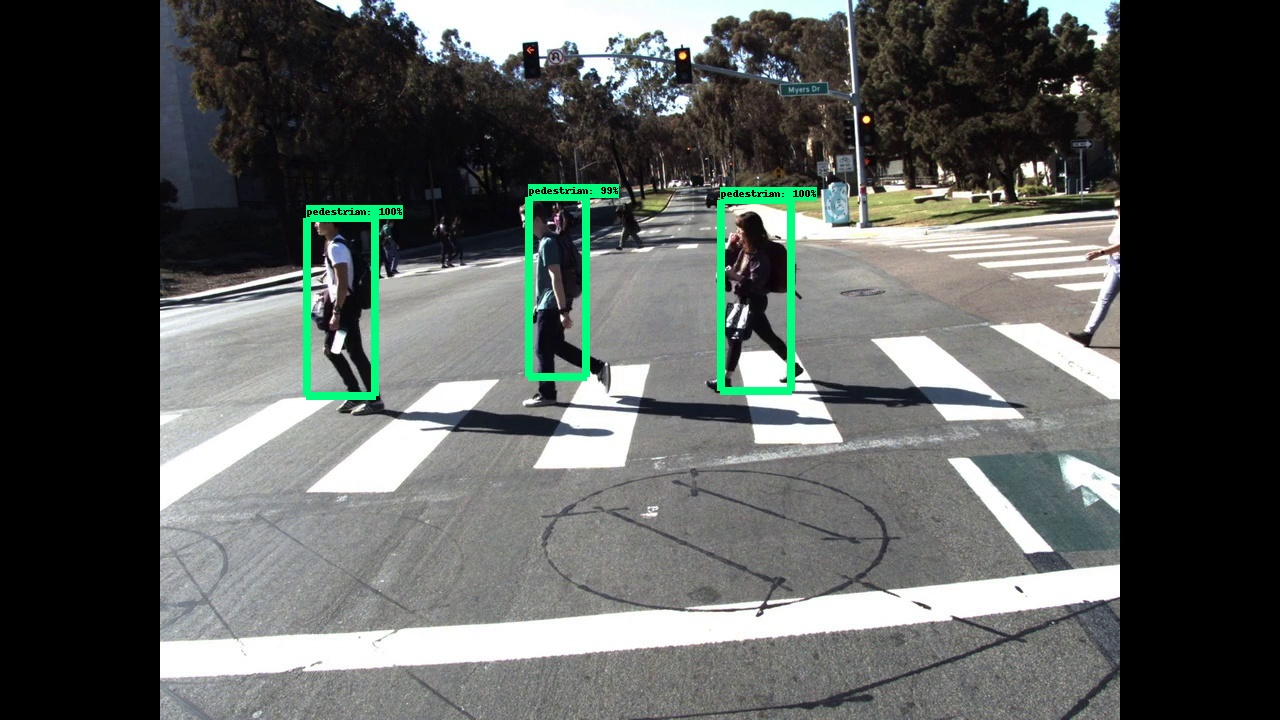

In [3]:
Image(filename="../RESULTS_faster_rcnn/left_view/frame100.jpg") 

# II. Running Inference with Mask-RCNN

The following code is an adaptation of the demo code that comes with the Mask-RCNN directory, with some modifications to work on our input data, and a modification on the visualization script to save output images with overlaid masks. 

In [4]:
# Root directory of the project
ROOT_DIR = os.path.abspath("../Mask_RCNN_modified/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize

# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "./mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Device to load the neural network on.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
TEST_MODE = "inference"

### Configure/Create Inference Model and Load Trained Weights


We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [5]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 720
    IMAGE_MAX_DIM = 1280

config = InferenceConfig()
config.display()

with tf.device(DEVICE):
    # Create model object in inference mode.
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

    # Load weights trained on MS-COCO
    model.load_weights(COCO_MODEL_PATH, by_name=True)


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1280
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  720
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1280 1280    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

### Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

We include the hard-coded classnames corresponding to their class IDs below so you don't have to download the Coco dataset to run inference. 

In [6]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

### Modified Visualization Code To Save Images

In [7]:
def display_imgs(filename, image, boxes, masks, class_ids, class_names,
                 scores=None, title="",
                 figsize=(14, 14), ax=None,
                 show_mask=True, show_bbox=True,
                 colors=None, captions=None, show=False):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    # Turn interactive plotting off
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        fig, ax = plt.subplots(1, figsize=figsize)

    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    # Generate random colors
    colors = colors or visualize.random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        if (class_ids[i] == 1):
            color = colors[i]

            # Bounding box
            if not np.any(boxes[i]):
                # Skip this instance. Has no bbox. Likely lost in image cropping.
                continue
            y1, x1, y2, x2 = boxes[i]
            if show_bbox:
                p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                    alpha=0.7, linestyle="dashed",
                                    edgecolor=color, facecolor='none')
                ax.add_patch(p)

            # Label
            if not captions:
                class_id = class_ids[i]
                score = scores[i] if scores is not None else None
                label = class_names[class_id]
                x = random.randint(x1, (x1 + x2) // 2)
                caption = "{} {:.3f}".format(label, score) if score else label
            else:
                caption = captions[i]
            ax.text(x1, y1 + 8, caption,
                    color='w', size=11, backgroundcolor="none")

            # Mask
            mask = masks[:, :, i]
            if show_mask:
                masked_image = visualize.apply_mask(masked_image, mask, color)

            # Mask Polygon
            # Pad to ensure proper polygons for masks that touch image edges.
            padded_mask = np.zeros(
                (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
            padded_mask[1:-1, 1:-1] = mask
            contours = find_contours(padded_mask, 0.5)
            for verts in contours:
                # Subtract the padding and flip (y, x) to (x, y)
                verts = np.fliplr(verts) - 1
                p = Polygon(verts, facecolor="none", edgecolor=color)
                ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))
    if show: plt.show()
    fig.savefig(filename, bbox_inches = 'tight', pad_inches = 0)
    plt.close("all")

### Load both sets of images (left_view, right_view) to perform inference

In [8]:
# Input and output directories for both sets of images
IMAGE_DIRS = ['../input_images/left_view/', '../input_images/right_view/']
SAVE_DIRS = ['../RESULTS_mask_rcnn/left_view/', '../RESULTS_mask_rcnn/right_view/']
DEPTH_SAVE_DIRS = ['../RESULTS_mask_rcnn_depth/left_view/', '../RESULTS_mask_rcnn_depth/right_view/']

images = [[],[]] 
names = [[],[]]
for d in range(len(IMAGE_DIRS)):
    images[d] = []
    names[d] = []
    ord_names = []

    for filename in os.listdir(IMAGE_DIRS[d]):
        try:
            img = skimage.io.imread(os.path.join(IMAGE_DIRS[d], filename))
            if img is not None:
                images[d].append(img)
                names[d].append(filename)
                ord_names.append(int(filename[5:].split('.')[0]))
        except:
            print('Cant import ' + filename)    
    
    # order the images by name to know in order which frame they belong
    zipped = sorted(zip(ord_names, names[d], images[d]))
    ord_names, names[d], images[d] = zip(*zipped)

Cant import .ipynb_checkpoints
Cant import .ipynb_checkpoints


### Perform Inference with Mask-RCNN and visualize/save results

We perform inference on the left/right view input images from the loaded Mask-RCNN model, and visualize one of the images here. We run the display_save_imgs function (written above) to save the images with pedestrian bounding boxes and drawn masks in the specified SAVE_DIRS, if they don't already exist in that folder.

Visualizing results from inference for image:  frame100.jpg


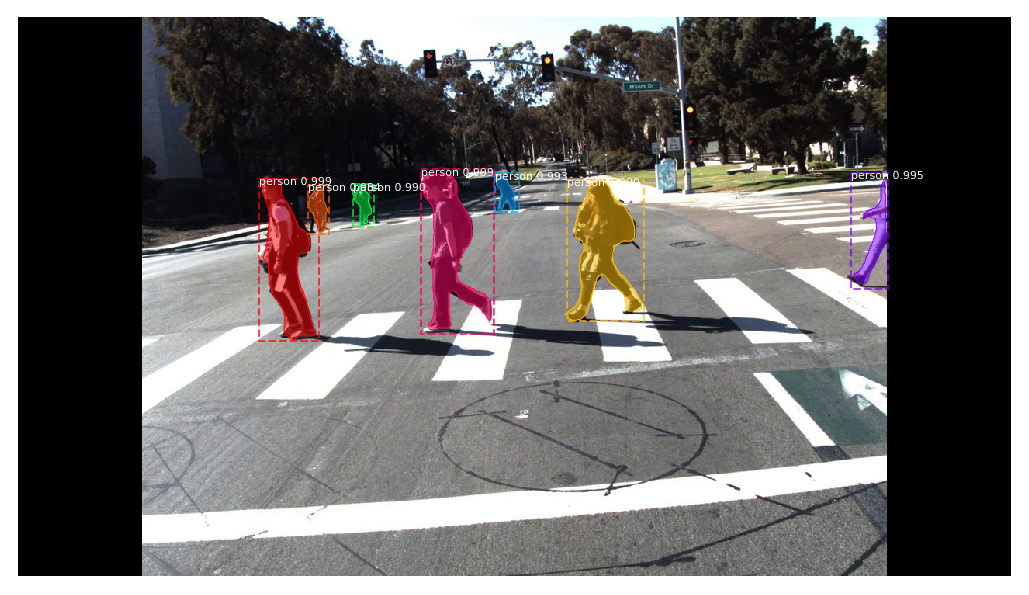

In [9]:
results = [[],[]]
demo_result = [0,0]
save = False
demo = True
for d in range(len(IMAGE_DIRS)):
    imgs = images[d]
    nam = names[d]
    # If we are doing this for the demo, only do inference for frame100.jpg
    # (saves time) and display this image. If not for demo (if you actually want
    # to generate images and save to directory, set demo = False)
    
    # in the else clause, we run inference for all images and save them to the SAVE_DIR. 
    if demo: 
        with tf.device(DEVICE): 
            demo_result[d] = model.detect([imgs[100]]);
        r = demo_result[d][0]
        print ("Visualizing results from inference for image: ", nam[100])
        display_imgs(SAVE_DIRS[d]+"/proc_"+nam[100], imgs[100], r['rois'], r['masks'], r['class_ids'], class_names, r['scores'], show=True)      
        break
    else: 
        for i in range(len(imgs)):
            with tf.device(DEVICE): 
                results[d].append(model.detect([imgs[i]]));
            r = results[d][i][0]
            display_imgs(SAVE_DIRS[d]+"/proc_"+nam[i], imgs[i], r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])


# III. Using PSMNet to estimate pedestrian depth
In the following section, we will estimate pedestrian depth by running inference on a convolutional neural network developed in March 2018 by Chang and Chen. Pyramid Stereo Matching Networks (PSMNet) uses spatial pyramid pooling to aggregate context in different scales and locations to form a cost volume, and 3D CNNs to regularize this volume using stacked hourglass networks.

In [ ]:
## RESTART KERNEL AS WE WILL BE USING PYTORCH NOW
restartkernel()

In [1]:
# Reimport everything
import argparse
import os
import sys
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
import time
import math
import cv2
from IPython.display import Image

ROOT_DIR = os.path.abspath("../PSMNet-modified/")
sys.path.append(ROOT_DIR)
from stackhourglass import PSMNet

print (torch.cuda.is_available())

True


In [2]:
__imagenet_stats = {'mean': [0.485, 0.456, 0.406],
                   'std': [0.229, 0.224, 0.225]}

def scale_crop(input_size, scale_size=None, normalize=__imagenet_stats):
    t_list = [
        transforms.ToTensor(),
        transforms.Normalize(**normalize),
    ]
    return transforms.Compose(t_list)

def get_transform(name='imagenet', input_size=None,
                  scale_size=None, normalize=None):
    normalize = __imagenet_stats
    input_size = 256
    return scale_crop(input_size=input_size, scale_size=scale_size, normalize=normalize)

def test(imgL,imgR):
    model = PSMNet(192)
    model = nn.DataParallel(model, device_ids=[0])
    model.cuda()
    state_dict = torch.load('../PSMNet-modified/pretrained_model_KITTI2012.tar')
    model.load_state_dict(state_dict['state_dict'])
    model.eval()

    imgL = imgL[155:155+384,:,:]
    imgR = imgR[155:155+384,:,:]
    imgL = cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB)
    imgR = cv2.cvtColor(imgR, cv2.COLOR_BGR2RGB)

    processed = get_transform()

    imgL = processed(imgL).numpy()
    imgR = processed(imgR).numpy()

    imgL = np.reshape(imgL,[1,3,imgL.shape[1],imgL.shape[2]])
    imgR = np.reshape(imgR,[1,3,imgR.shape[1],imgR.shape[2]])
    print(imgL.shape)

    # pad to (384, 1248)
    top_pad = 384-imgL.shape[2]
    left_pad = 1248-imgL.shape[3]
    imgL = np.lib.pad(imgL,((0,0),(0,0),(top_pad,0),(0,left_pad)),mode='constant',constant_values=0)
    imgR = np.lib.pad(imgR,((0,0),(0,0),(top_pad,0),(0,left_pad)),mode='constant',constant_values=0)

    imgL = torch.FloatTensor(imgL).cuda()
    imgR = torch.FloatTensor(imgR).cuda()

    imgL, imgR = Variable(imgL), Variable(imgR)
    
    with torch.no_grad():
        output = model(imgL,imgR)
    output = torch.squeeze(output)
    pred_disp = output.data.cpu().numpy()

    return pred_disp

### For the sake of our demo, we display the depth map of the images shown in the previous sections with their bounding boxes from both Mask-RCNN and Faster-RCNN.

Reading in computed depth maps
(1, 3, 384, 946)


/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1749: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


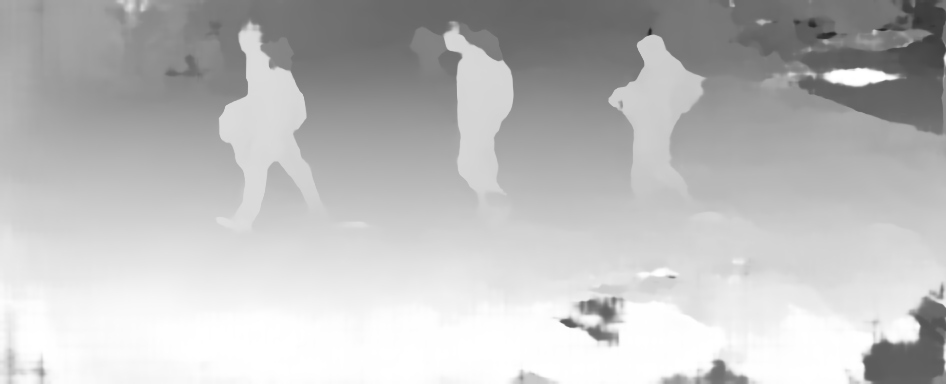

In [3]:
#load images
DEPTH_DIR = '../input_images/rectified/'
print ("Reading in computed depth maps")

image_l = cv2.imread(os.path.join(DEPTH_DIR, 'left90.png'))
image_r = cv2.imread(os.path.join(DEPTH_DIR, 'right90.png'))

pred_disp = test(image_l,image_r)
left_pad  = 1248-946
img = pred_disp[0:,:-left_pad]
img = img*(255/np.max(img))
outname = "depth_90.png"
cv2.imwrite("../RESULTS_depth/"+outname,img)

Image(filename="../RESULTS_depth/"+outname) 